In [2]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from joblib import delayed, Parallel
from scipy import stats
from sklearn.utils import resample

#plt.style.use('seaborn-white')

nested_defaultdict = lambda: defaultdict(nested_defaultdict)

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['grid.color']='white'

In [4]:
with open('../results/varying_seqid_cutoff_predictions.json', 'r') as f:
    predictions = json.load(f)
    
with open('../results/varying_seqid_cutoff_similar_ligands_removed_predictions.json', 'r') as f:
    predictions_lf = json.load(f)

In [5]:
with open('../results/test_set_binding_data.json', 'r') as f:
    binding_data = json.load(f)

In [6]:
def permutation_test(y_true, y_pred, n_samples=100000, return_dist=False, random_state=42):
    try:
        assert len(y_true) == len(y_pred), f"Shape of y_true and y_pred do not match: {len(y_true)} != {len(y_pred)}"
    except AssertionError as e:
        print(e)
        return
    rng = np.random.RandomState(seed=random_state)
    results = np.zeros(n_samples)
    for i in range(n_samples):
        permuted = resample(y_true, random_state=rng, replace=False)
        results[i] = stats.pearsonr(permuted, y_pred)[0]
        
    r = stats.pearsonr(y_true, y_pred)[0]
    
    # for finite m Monte Carlo repetitions with b occurences, p-value estimate is p = (b + 1) / (m + 1)
    b = len([result for result in results if result > r])
    p = (b + 1) / (n_samples + 1)

    if return_dist:
        return r, p, results
    else:
        return r, p

In [7]:
def bootstrap_ci(y_true, y_pred, ci=0.95, n_samples=100000, return_dist=False, random_state=42):
    try:
        assert len(y_true) == len(y_pred), f"Shape of y_true and y_pred do not match: {len(y_true)} != {len(y_pred)}"
    except AssertionError as e:
        print(e)
        return
    rng = np.random.RandomState(seed=random_state)
    results = np.zeros(n_samples)
    for i in range(n_samples):
        true, pred = resample(y_true, y_pred, random_state=rng)
        results[i] = stats.pearsonr(true, pred)[0]
      
    # define interval
    p_lower = ((1 - ci) / 2) * 100
    p_upper = (ci + ((1 - ci) / 2)) * 100
    lower, upper = np.percentile(results, [p_lower, p_upper])
    r = stats.pearsonr(y_true, y_pred)[0]
    if return_dist:
        return r, lower, upper, results
    else:
        return r, lower, upper

In [8]:
blast_cutoffs = [i for i in predictions]
release_years = [str(i) for i in [2013, 2014, 2015, 2016, 2017, 2018]]
training_sets = [f'{y} refined' for y in release_years] + [f'{y} general' for y in release_years]
feature_sets = [i for i in predictions['None']['2013 general']]
core_sets = [str(i) for i in [2007, 2013, 2016, 'all']] #skip union of core sets for now

# Bootstrap results when similar ligands are not excluded

In [9]:
all_models = list(itertools.product(blast_cutoffs, training_sets, feature_sets, core_sets))
all_predictions = [predictions[m[0]][m[1]][m[2]][m[3]] for m in all_models]
all_true = [binding_data[m[3]] for m in all_models] # memory inefficient, but cba changing anything else

In [10]:
# bootstrap ci and permutation test
with Parallel(n_jobs=64, verbose=10) as parallel:
    bootstrap_results = parallel(delayed(bootstrap_ci)(y_true, y_pred, n_samples=10000, return_dist=True) for y_true, y_pred in zip(all_true, all_predictions))
    permutation_results = parallel(delayed(permutation_test)(y_true, y_pred, n_samples=10000, return_dist=True) for y_true, y_pred in zip(all_true, all_predictions))

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  17 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=64)]: Done  53 tasks      | elapsed:    9.0s
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   10.5s
[Parallel(n_jobs=64)]: Done  93 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 114 tasks      | elapsed:   12.9s
[Parallel(n_jobs=64)]: Done 137 tasks      | elapsed:   14.7s
[Parallel(n_jobs=64)]: Done 160 tasks      | elapsed:   16.0s
[Parallel(n_jobs=64)]: Done 185 tasks      | elapsed:   17.8s
[Parallel(n_jobs=64)]: Done 210 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 237 tasks      | elapsed:   21.1s
[Parallel(n_jobs=64)]: Done 264 tasks      | elapsed:   22.8s
[Parallel(n_jobs=64)]: Done 293 tasks      | elapsed:   24.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   26.3s
[Parallel(n_jobs=64)]: Done 353 tasks      | elapsed:  

# Bootstrap results when similar ligands are excluded

In [11]:
all_models = list(itertools.product(blast_cutoffs, training_sets, feature_sets, core_sets))
all_predictions_lf = [predictions_lf[m[0]][m[1]][m[2]][m[3]] for m in all_models]
all_true = [binding_data[m[3]] for m in all_models] # memory inefficient, but cba changing anything else

In [12]:
# bootstrap ci and permutation test
with Parallel(n_jobs=64, verbose=10) as parallel:
    bootstrap_results_lf = parallel(delayed(bootstrap_ci)(y_true, y_pred, n_samples=10000, return_dist=True) for y_true, y_pred in zip(all_true, all_predictions_lf))
    permutation_results_lf = parallel(delayed(permutation_test)(y_true, y_pred, n_samples=10000, return_dist=True) for y_true, y_pred in zip(all_true, all_predictions_lf))

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done  53 tasks      | elapsed:    5.8s
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done  93 tasks      | elapsed:    9.0s
[Parallel(n_jobs=64)]: Done 114 tasks      | elapsed:   10.5s
[Parallel(n_jobs=64)]: Done 137 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 160 tasks      | elapsed:   14.0s
[Parallel(n_jobs=64)]: Done 185 tasks      | elapsed:   15.9s
[Parallel(n_jobs=64)]: Done 210 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done 237 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 264 tasks      | elapsed:   21.2s
[Parallel(n_jobs=64)]: Done 293 tasks      | elapsed:   23.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   25.8s
[Parallel(n_jobs=64)]: Done 353 tasks      | elapsed:  

In [13]:
labels = ['RDKit', 'Vina', 'Vina + RDKit', 'RF-Score', 'RF-Score + RDKit', 'RF-Score v3', 'RF-Score v3 + RDKit', 'NNScore 2.0', 'NNScore 2.0 + RDKit']

In [14]:
confidence_interval = nested_defaultdict()
bootstrapped_distribution = nested_defaultdict()
for model, result in zip(all_models, bootstrap_results):
    confidence_interval[model[0]][model[1]][model[2]][model[3]] = result[:-1]
    bootstrapped_distribution[model[0]][model[1]][model[2]][model[3]] = result[-1].tolist()

In [15]:
confidence_interval_lf = nested_defaultdict()
bootstrapped_distribution_lf = nested_defaultdict()
for model, result in zip(all_models, bootstrap_results_lf):
    confidence_interval_lf[model[0]][model[1]][model[2]][model[3]] = result[:-1]
    bootstrapped_distribution_lf[model[0]][model[1]][model[2]][model[3]] = result[-1].tolist()

In [16]:
plt.style.use('seaborn-white')

In [17]:
def plot_ci(value, lower, upper, labels, ticks=None, bar_height=0.8, ax=None):
    if ax is None:
        ax = plt.gca()
    if ticks is None:
        ticks = np.arange(len(labels))
    ax.scatter(value, ticks, s=100, marker='o', zorder=1, label='Test')
    ax.barh(ticks, upper - lower, left=lower, zorder=0, label='95% CI', color='w', edgecolor='k')
    ax.legend(loc='best')
    ax.set_yticklabels(labels)
    ax.set_xlim(0.4, 0.9)
    ax.set_xlabel('Pearson correlation coefficient')
    ax.grid(False)
    ax.set_yticks(ticks)

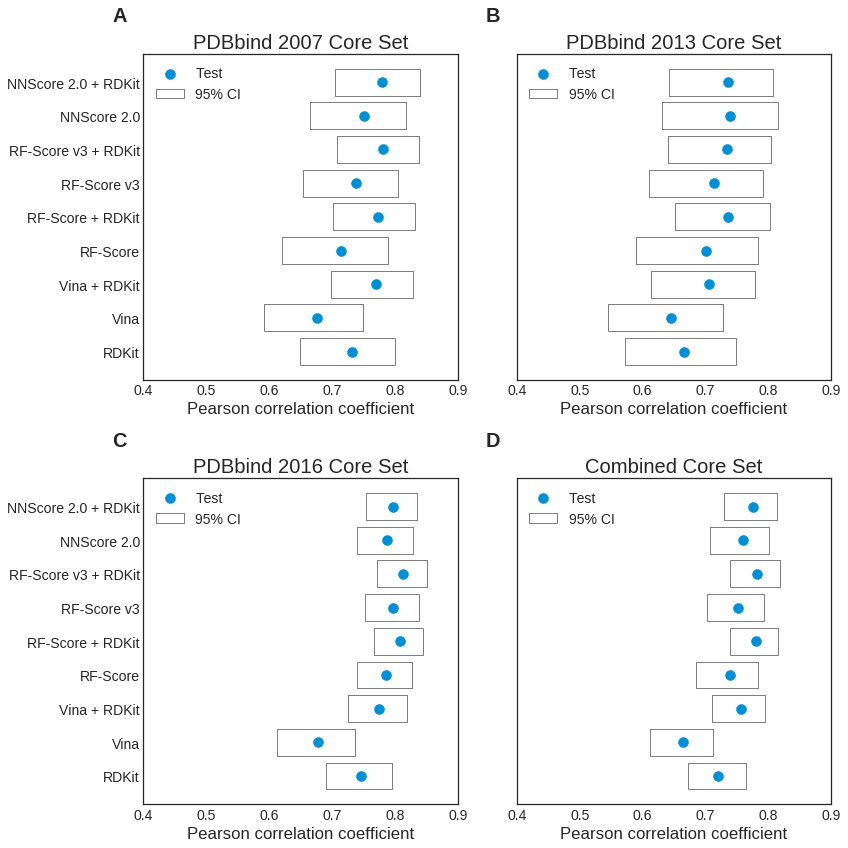

In [18]:
cutoff = 'None'
training_data = '2018 refined'

fig, axes = plt.subplots(2,2, figsize=(12,12), sharey=True)

ci = {f: confidence_interval[cutoff][training_data][f]['2007'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][0])
axes[0][0].set_title('PDBbind 2007 Core Set')
axes[0][0].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['2013'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][1])
axes[0][1].set_title('PDBbind 2013 Core Set')
axes[0][1].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['2016'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][0])
axes[1][0].set_title('PDBbind 2016 Core Set')
axes[1][0].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['all'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][1])
axes[1][1].set_title('Combined Core Set')
axes[1][1].legend(loc='upper left')


for ax, annotation in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
    
fig.tight_layout()
fig.show()
fig.savefig('../figures/pdbbind_2018_refined_95_ci.jpg', dpi=350, bbox_inches='tight')

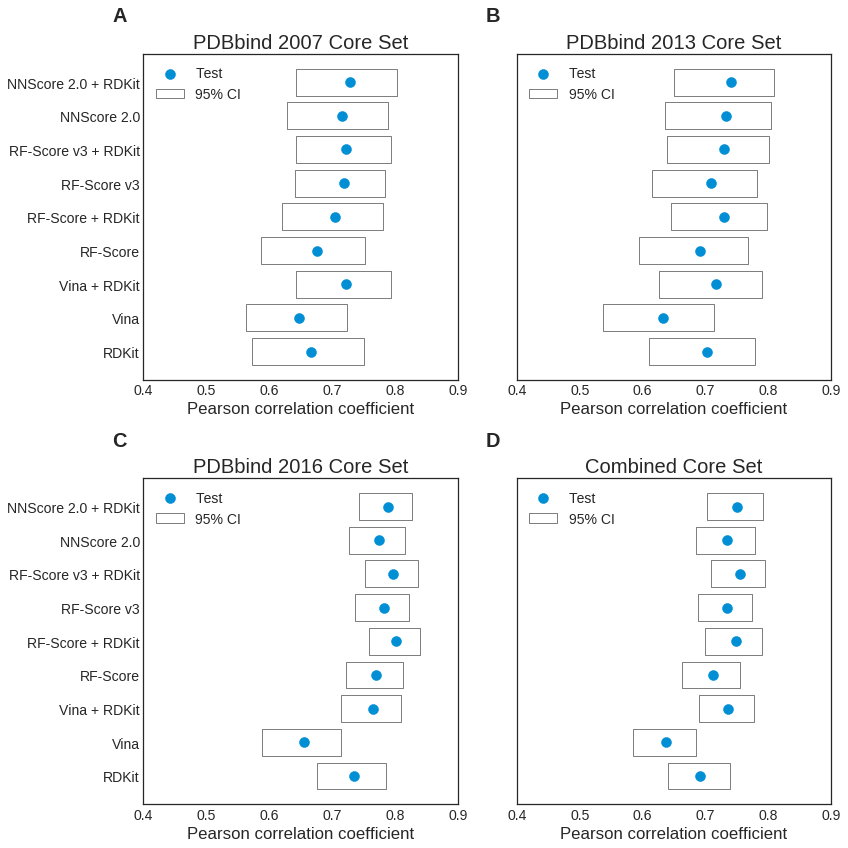

In [19]:
cutoff = 'None'
training_data = '2018 refined'

fig, axes = plt.subplots(2,2, figsize=(12,12), sharey=True)

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2007'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][0])
axes[0][0].set_title('PDBbind 2007 Core Set')
axes[0][0].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2013'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][1])
axes[0][1].set_title('PDBbind 2013 Core Set')
axes[0][1].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2016'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][0])
axes[1][0].set_title('PDBbind 2016 Core Set')
axes[1][0].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['all'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][1])
axes[1][1].set_title('Combined Core Set')
axes[1][1].legend(loc='upper left')


for ax, annotation in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
    
fig.tight_layout()
fig.show()
fig.savefig('../figures/pdbbind_2018_refined_95_ci_ligand_filter.jpg', dpi=350, bbox_inches='tight')

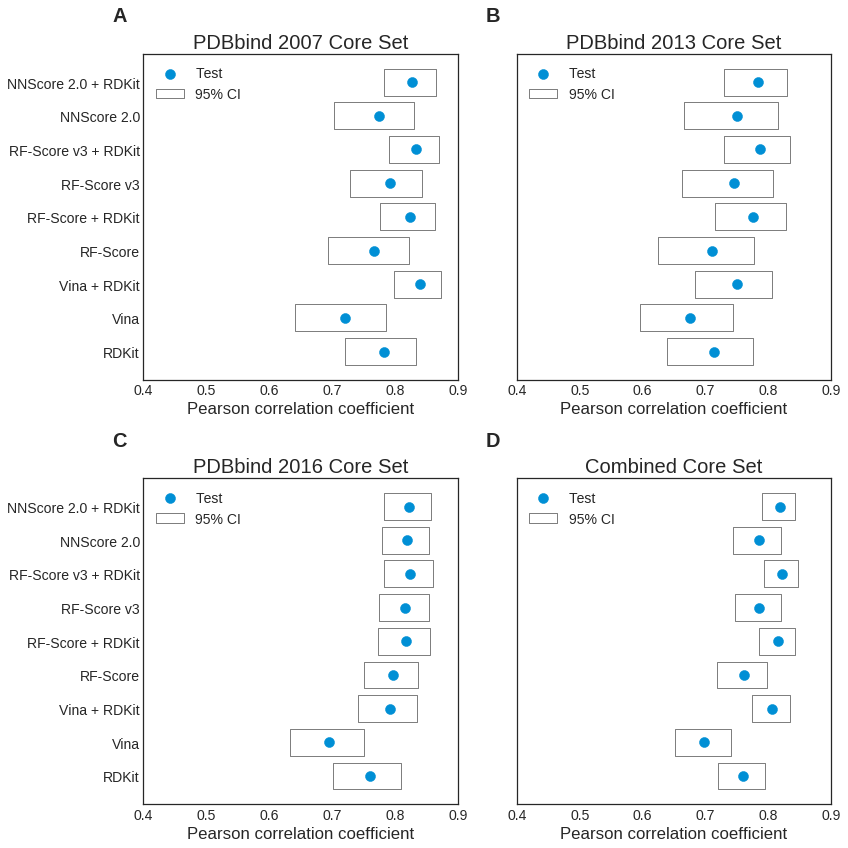

In [24]:
cutoff = 'None'
training_data = '2018 general'

fig, axes = plt.subplots(2,2, figsize=(12,12), sharey=True)

ci = {f: confidence_interval[cutoff][training_data][f]['2007'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][0])
axes[0][0].set_title('PDBbind 2007 Core Set')
axes[0][0].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['2013'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][1])
axes[0][1].set_title('PDBbind 2013 Core Set')
axes[0][1].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['2016'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][0])
axes[1][0].set_title('PDBbind 2016 Core Set')
axes[1][0].legend(loc='upper left')

ci = {f: confidence_interval[cutoff][training_data][f]['all'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][1])
axes[1][1].set_title('Combined Core Set')
axes[1][1].legend(loc='upper left')


for ax, annotation in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
    
fig.tight_layout()
fig.show()
fig.savefig('../figures/pdbbind_2018_general_95_ci.jpg', dpi=350, bbox_inches='tight')

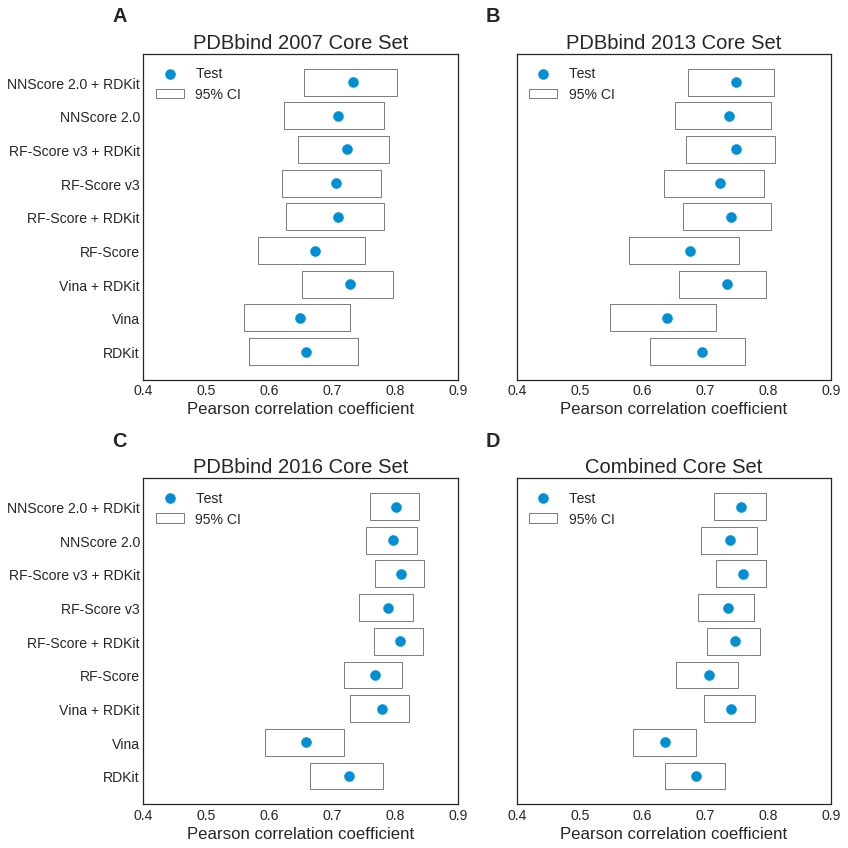

In [25]:
cutoff = 'None'
training_data = '2018 general'

fig, axes = plt.subplots(2,2, figsize=(12,12), sharey=True)

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2007'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][0])
axes[0][0].set_title('PDBbind 2007 Core Set')
axes[0][0].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2013'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[0][1])
axes[0][1].set_title('PDBbind 2013 Core Set')
axes[0][1].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['2016'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][0])
axes[1][0].set_title('PDBbind 2016 Core Set')
axes[1][0].legend(loc='upper left')

ci = {f: confidence_interval_lf[cutoff][training_data][f]['all'] for f in feature_sets}
df = pd.DataFrame(ci).T
df.columns = ['R', 'lower', 'upper']
df['upper'] = df['upper']
df['lower'] = df['lower']
df = df.loc[labels]

plot_ci(df['R'], df['lower'], df['upper'], labels, ax=axes[1][1])
axes[1][1].set_title('Combined Core Set')
axes[1][1].legend(loc='upper left')


for ax, annotation in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
    
fig.tight_layout()
fig.show()
fig.savefig('../figures/pdbbind_2018_general_95_ci_ligand_filter.jpg', dpi=350, bbox_inches='tight')

In [23]:
with open('../results/pearsonr_bootstrap_ci.json', 'w') as f:
    json.dump(confidence_interval, f)

Test for difference in distribution of bootstrapped correlation coefficients for each model with and without RDKit descriptors.

In [21]:
mwutest_results = nested_defaultdict()

for cutoff in blast_cutoffs:
    for data_set in training_sets:
        for feature_set in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
            for core_set in core_sets:
                y1 = bootstrapped_distribution[cutoff][data_set][feature_set][core_set]
                y2 = bootstrapped_distribution[cutoff][data_set][feature_set + ' + RDKit'][core_set]
                mwutest_results[cutoff][data_set][feature_set][core_set] = stats.mannwhitneyu(y1, y2, alternative='two-sided')
                p = mwutest_results[cutoff][data_set][feature_set][core_set][1]
                if p > 0.05:
                    print(cutoff, data_set, feature_set, core_set, p)

40 2018 general RF-Score 2016 0.19251566370953654
40 2018 general NNScore 2.0 2016 0.8118203437407905
50 2017 general RF-Score v3 2016 0.45214664756664225
50 2018 general RF-Score v3 2016 0.8481051018618554
50 2018 general NNScore 2.0 2016 0.8370697900090753
70 2017 general NNScore 2.0 2016 0.08767453225538831
70 2018 general RF-Score v3 2016 0.6314914210068512
90 2015 refined NNScore 2.0 2013 0.07669941386055457
90 2017 refined NNScore 2.0 2013 0.2990589328162001
90 2018 refined NNScore 2.0 2013 0.22890758037845793
90 2018 general RF-Score v3 2016 0.3055035854557583
95 2014 refined NNScore 2.0 2013 0.20126053190699023
95 2018 refined NNScore 2.0 2013 0.27897202900812124
100 2013 refined NNScore 2.0 2016 0.4362869218098091
None 2017 refined NNScore 2.0 2013 0.48127793114535233


In [22]:
mwutest_results_lf = nested_defaultdict()

for cutoff in blast_cutoffs:
    for data_set in training_sets:
        for feature_set in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
            for core_set in core_sets:
                y1 = bootstrapped_distribution_lf[cutoff][data_set][feature_set][core_set]
                y2 = bootstrapped_distribution_lf[cutoff][data_set][feature_set + ' + RDKit'][core_set]
                mwutest_results_lf[cutoff][data_set][feature_set][core_set] = stats.mannwhitneyu(y1, y2, alternative='two-sided')
                p = mwutest_results_lf[cutoff][data_set][feature_set][core_set][1]
                if p > 0.05:
                    print(cutoff, data_set, feature_set, core_set, p)

30 2014 refined RF-Score v3 2013 0.11336994368433854
30 2014 refined NNScore 2.0 2016 0.9047286435726596
30 2015 general NNScore 2.0 2016 0.17170813447531785
30 2018 general RF-Score v3 2016 0.13865509842702092
40 2018 general RF-Score v3 2016 0.21692873935379964
50 2018 refined NNScore 2.0 2016 0.726228357379846
50 2017 general NNScore 2.0 2016 0.31953700418628217
50 2018 general NNScore 2.0 2016 0.7845577509652562
70 2018 refined NNScore 2.0 2013 0.3183321921343185
70 2016 general NNScore 2.0 2016 0.9837300936022904
95 2015 refined NNScore 2.0 2013 0.1058764245112781
100 2015 refined NNScore 2.0 2013 0.923151573419766
100 2017 refined NNScore 2.0 2013 0.07445019986698571
None 2013 general NNScore 2.0 2016 0.28450696566280276
